# <center>tf.KerasによるSkip-GANomaly</center>

異常検知を実装して見ましょう。このコードを元にGANomalyなども簡単に実装できるので、性能を比較してみると良い。



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

今回使うモデルのサイズと深さを決めておきましょう：

In [2]:
SIZE = 32
DEPTH = 4
DATASET_PATH = './save_weight/SkipGANormaly'

# 1. モデルの作成

ジェネレータはUNetベースなので、もう勉強済みなので実装は簡単。ただ今回はインスタンス規格化を使うので、TensorFlow Addonsをインストールする。

pip install tensorflow-addon

以下の部品は、ほぼ以前のUNetの実装の通り：

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Input

from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.initializers import RandomNormal

gamma_initializer = RandomNormal(mean=0.0, stddev=0.02)

## Generator 

In [4]:
class conv_block(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size, Dropout=False, Maxpool=True):
        super(conv_block, self).__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.dropout = Dropout
        self.maxpool = Maxpool
        
        self.layer1 = layers.Conv2D(self.n_channels, self.kernel_size, padding='same')
        self.norm1 = InstanceNormalization()
        self.layer2 = layers.Conv2D(self.n_channels, self.kernel_size, padding='same')
        self.norm2 = InstanceNormalization()
        self.maxlayer = layers.MaxPool2D((2,2),padding='same')
        
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.norm1(x)
        x = layers.LeakyReLU(0.2)(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = layers.LeakyReLU(0.2)(x)
        down = x
        
        if self.dropout == True:
            x = layers.Dropout(0.5)(x)
        
        if self.maxpool == True:
            x = self.maxlayer(x)

        return x, down
    
class upconv_block(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size):
        super(upconv_block, self).__init__()
        self.n_channels = n_channels
        
        self.layer1 = layers.Conv2D(self.n_channels, (2,2), padding='same')
        self.norm1 = InstanceNormalization()
        self.layer2 = layers.Conv2D(self.n_channels, (3,3), padding='same')
        self.norm2 = InstanceNormalization()
        
    def call(self, inputs, downsampling_layers):
        # Upsamplingでサイズを倍にした後、2x2 Convでチャネル数を変更。TransposeConvを使うのでも良い
        x = layers.UpSampling2D((2, 2))(inputs)
        x = self.layer1(x)
        x = self.norm1(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Concatenate()([x, downsampling_layers])
        x = self.layer2(x)
        x = self.norm2(x)
        x = layers.Activation('relu')(x)

        return x

In [5]:
class Generator(tf.keras.Model):
    def __init__(self, size, depth):
        super(Generator, self).__init__()
        self.size = size
        self.depth = depth
        self.n_classes = 3
        
        self.encoder1 = conv_block(64, 3)
        self.encoder2 = conv_block(128,3)
        self.encoder3 = conv_block(256,3)
        self.encoder4 = conv_block(512,3,True)
        self.encoder5 = conv_block(1024,3,True,False)
        
        self.decoder1 = upconv_block(512,3)
        self.decoder2 = upconv_block(256,3)
        self.decoder3 = upconv_block(128,3)
        self.decoder4 = upconv_block(64,3)
        
        self.last_layer = layers.Conv2D(self.n_classes, (1,1), padding='same', activation='tanh')
        
    def call(self, inputs):
        downsampling_layers = []
        
        x, down = self.encoder1(inputs)
        downsampling_layers.append(down)
        
        x, down = self.encoder2(x)
        downsampling_layers.append(down)
        
        x, down = self.encoder3(x)
        downsampling_layers.append(down)
        
        x, down = self.encoder4(x)
        downsampling_layers.append(down)
        
        x, _ = self.encoder5(x)
        x = layers.Dropout(0.5)(x)
        downsampling_layers = downsampling_layers[::-1] #ひっくり返す
        
        x = self.decoder1(x,downsampling_layers[0])
        x = self.decoder2(x,downsampling_layers[1])
        x = self.decoder3(x,downsampling_layers[2])
        x = self.decoder4(x,downsampling_layers[3])
        x = self.last_layer(x)

        return x
    
    #Subclass APIでSummaryを作るために利用する関数
    def my_summary(self, input_shape):
        
        tmp_x = Input(shape=input_shape, name='tmp_input')
        tmp_m = Model(inputs=tmp_x, outputs=self.call(tmp_x), name='tmp_model')
        tmp_m.summary()
        del tmp_x, tmp_m

In [6]:
generator = Generator(size=(SIZE,SIZE,3),depth=DEPTH)
generator.my_summary((SIZE,SIZE,3))

Model: "tmp_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tmp_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_block (conv_block)         ((None, 16, 16, 64), 38976       tmp_input[0][0]                  
__________________________________________________________________________________________________
conv_block_1 (conv_block)       ((None, 8, 8, 128),  221952      conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_2 (conv_block)       ((None, 4, 4, 256),  886272      conv_block_1[0][0]               
__________________________________________________________________________________________

## Discriminator
latent lossの計算に最後の畳み込み層の出力も必要になるので、シグモイド出力と特徴マップ出力のペアを出力するモデルとした。

In [7]:
class D_conv_block(tf.keras.layers.Layer):
    def __init__(self, kernel_size=(3,3), n_channels=32, norm=True):
        super(D_conv_block,self).__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.norm = norm
        
        self.layer1 = layers.Conv2D(n_channels, kernel_size, padding='same')
        self.norm1 = InstanceNormalization()
        self.layer2 = layers.Conv2D(n_channels, kernel_size, strides=2, padding='same')
        self.norm2 = InstanceNormalization()
        
    def call(self,inputs):
        x = self.layer1(inputs)
        x = self.norm1(x)
        x = layers.LeakyReLU(0.2)(x)
        x = self.layer2(x)
        
        if self.norm == True:
            x = self.norm2(x)
            
        x = layers.LeakyReLU(0.2)(x)

        return x

In [8]:
class Discriminator(tf.keras.Model):
    def __init__(self, size, kernel_size=(3,3), n_channels=32):
        super(Discriminator, self).__init__()
        self.size = size
        
        self.layer1 = D_conv_block(n_channels=64)
        self.layer2 = D_conv_block(n_channels=128)
        self.layer3 = D_conv_block(n_channels=256)
        self.layer4 = D_conv_block(n_channels=512)
        self.layer5 = D_conv_block(n_channels=100,norm=False)
        self.final = layers.Dense(1)
        
    def call(self,inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        f = self.layer5(x)
        f = layers.Flatten()(f)
        x = self.final(f)
        x = layers.Activation('sigmoid')(x)
        
        return [f, x]
    
    #summaryを表示させるための関数
    def my_summary(self, input_shape=(256,256,1)):
        tmp_x = Input(shape=input_shape, name='tmp_input')
        tmp_m = Model(inputs=tmp_x, outputs=self.call(tmp_x), name='tmp_model')
        tmp_m.summary()
        del tmp_x, tmp_m

In [9]:
discriminator = Discriminator(size=(SIZE,SIZE,3))
discriminator.my_summary((SIZE,SIZE,3))

Model: "tmp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tmp_input (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
d_conv_block (D_conv_block)  (None, 16, 16, 64)        38976     
_________________________________________________________________
d_conv_block_1 (D_conv_block (None, 8, 8, 128)         221952    
_________________________________________________________________
d_conv_block_2 (D_conv_block (None, 4, 4, 256)         886272    
_________________________________________________________________
d_conv_block_3 (D_conv_block (None, 2, 2, 512)         3542016   
_________________________________________________________________
d_conv_block_4 (D_conv_block (None, 1, 1, 100)         551200    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0 

あとで必要になるので、latent lossに使う特徴量の次元を取得しておく：

In [10]:
#latent_dim = discriminator.output[0].shape[1]
latent_dim = 100

In [11]:
optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5, beta_2=0.999)

# 2. 学習の準備

今回のモデルは色々lossがあるので、trainingに使うモデルを工夫しておく。この辺りが実装で、工夫や頭を使う必要がある部分。このような様々な具体例を通じて、柔軟な実装の腕を鍛えてゆくこと。

では先ほど作った`generator`と`discrimiator`を使って、次のモデルを作ります：

In [12]:
# discriminatorを学習させるためのモデル
def build_discriminator():
    D_in0 = layers.Input((SIZE, SIZE, 3)) # real画像1
    D_in1 = layers.Input((SIZE, SIZE, 3)) # real画像2
    D_in2 = layers.Input((SIZE, SIZE, 3)) # real画像1から作ったfake画像

    _, D_out0= discriminator(D_in0) # real画像1の真偽判定
    f_1, _= discriminator(D_in1) # real画像2のlatent
    f_2, D_out2= discriminator(D_in2) # fake画像のlatentと真偽判定
    f_sub = layers.Subtract()([f_1,f_2]) # real画像2のlatent - fake画像のlatent。Dのlatent loss計算に使う

    # 出力は real画像1の真偽判定、real画像2の真偽判定、(real画像2のlatent - fake画像のlatent)
    gan_D = Model(inputs=[D_in0, D_in1, D_in2], outputs=[D_out0, D_out2, f_sub])
    
    return gan_D

gan_D = build_discriminator()

In [14]:
# generatorを学習させるためのモデル
def build_generator():
    discriminator.trainable = False
    
    G_in = layers.Input((SIZE, SIZE, 3)) # real画像

    x_hat = generator(G_in) # fake画像
    f_hat, G_out = discriminator(x_hat) # fake画像のlatentと真偽判定
    x_sub = layers.Subtract()([G_in,x_hat]) # real画像 - fake画像。contextual loss計算に使う

    f, _ = discriminator(G_in) # real画像のlatent
    f_G = layers.Subtract()([f_hat,f]) # real画像のlatent - fake画像のlatent。Gのlatent loss計算に使う
    
    # 出力は fake画像の真偽判定、(real画像 - fake画像)、(real画像のlatent - fake画像のlatent)
    gan_G = Model(inputs=G_in, outputs=[G_out, x_sub, f_G])

    return gan_G

gan_G = build_generator()

## loss関数の定義
 $L_{D}=L_{adv}+L_{lat}$ \
 $L_{G}=L_{adv}+40L_{con}+L_{lat}$ \
 $L_{lat}=(F(x)-F(\hat{x}))^{2}$
 $+_{con}=|x-\hat{x}|$

In [15]:
def discriminator_loss_function(t,pred):
    #loss1,loss2はL_advの計算
    #loss3 =latent lossにはy_true=0を与えてmseを計算すれば (real画像2のlatent - fake画像のlatent)**2 となる。
    loss1 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(t[0], pred[0]))
    loss2 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(t[1], pred[1]))
    loss3 = tf.reduce_mean(tf.keras.losses.MSE(t[2], pred[2]))
    
    D_loss = loss1+loss2+loss3
    
    return [D_loss, loss1, loss2, loss3]

def generator_loss_function(t, pred):
    # 出力は fake画像の真偽判定、(real画像 - fake画像)、(real画像のlatent - fake画像のlatent)
    # contextual lossにはy_true=0を与えてmaeを計算すれば |real画像 - fake画像| となる。
    loss1 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(t[0], pred[0]))
    loss2 = tf.reduce_mean(tf.keras.losses.MAE(t[1], pred[1]))
    loss3 = tf.reduce_mean(tf.keras.losses.MSE(t[2], pred[2]))
    
    G_loss = loss1 * 1 + loss2 * 40 + loss3 * 1
    
    return [G_loss, loss1, loss2, loss3]

## tf.GradientTapeの設定

In [16]:
@tf.function
def discriminator_train_step(x, t):
    with tf.GradientTape() as tape:
        D_pred = gan_D(x, training=True)
        D_loss = discriminator_loss_function(t, D_pred)
    gradients = tape.gradient(D_loss[0], gan_D.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gan_D.trainable_variables))
    
    return D_loss

@tf.function
def generator_train_step(x, t):
    with tf.GradientTape() as tape:
        G_pred = gan_G(x)
        G_loss = generator_loss_function(t, G_pred)
    
    gradients = tape.gradient(G_loss[0], gan_G.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gan_G.trainable_variables))
    
    return G_loss

# 3. 学習

まずは、CIFAR10の訓練データから0番目の飛行機クラスを除いたものを正常訓練データ`x_train`とする。

CIFAR10の訓練データの飛行機画像と、テストデータの飛行機画像を合わせてテスト用の異常画像`x_test_anom`とする。また、テストデータの飛行機画像以外をテスト用の正常画像`x_test_normal`とする。


<b>ここでは一気にテストデータを使ったが、本当は検証データを用意して正しくやること！</b>

In [17]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train,y_train), (x_test,y_test)=cifar10.load_data()

anom_class = 0

x_train = x_train.astype('float32')/127.5 - 1
x_test = x_test.astype('float32')/127.5 - 1

x_test_anom = np.concatenate([x_train[np.squeeze(y_train)==anom_class], x_test[np.squeeze(y_test)==anom_class]], axis=0)
x_train = x_train[np.squeeze(y_train)!=anom_class]
x_test_normal = x_test[np.squeeze(y_test)!=anom_class]

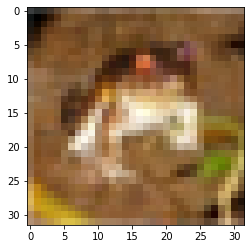

In [18]:
plt.imshow((x_train[0]+1)/2)

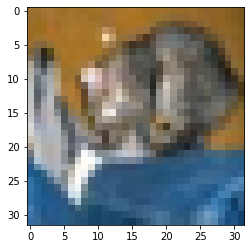

In [19]:
plt.imshow((x_test_normal[0]+1)/2)

In [20]:
x_train.shape

(45000, 32, 32, 3)

いつも通り訓練関数を作っておく
x_train.shape = (45000,32,32,3)
n_train = 45000
n_batch =128
y_real, y_fake (351)
y_dummy.shape(351, 100)
xhat_dummy.shape = (128,32,32,3)

In [21]:
d_history = []
g_history = []

def train(x_train, n_epochs, n_batch, x_val=x_test_normal):
    n_train = x_train.shape[0]
    bat_per_epoch = int(x_train.shape[0] / n_batch)
    y_real = np.ones((n_batch,1))
    y_fake = np.zeros((n_batch,1))
    y_dummy = np.zeros((n_batch, latent_dim)) # latent lossの計算にわたすy_true=0
    xhat_dummy = np.zeros((n_batch, )+ x_train.shape[1:]) # contextual lossの計算にわたすy_true=0

    for i in range(n_epochs):    
        for j in range(bat_per_epoch):
            #x_batch_0.shape, xhat_batch, x_batch=(32,32,32,3)
            #y_real,y_fake=(32,1) y_dummy=(32,100)
            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch_0 = x_train[idxes]
            
            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch = x_train[idxes]
            xhat_batch = generator.predict(x_batch)
            
            d_loss = discriminator_train_step([x_batch_0, x_batch, xhat_batch], [y_real, y_fake, y_dummy])
            d_history.append(d_loss)
            
            #xhat_dummy=(32,32,32,3)
            idxes = np.random.choice(list(range(n_train)), n_batch)
            x_batch = x_train[idxes]
            g_loss = generator_train_step(x_batch, [y_real, xhat_dummy, y_dummy])
            g_history.append(g_loss)

            if j  == 0:
                print('epoch', i)
                print('D', d_loss[0], ', G', g_loss[0])
                print('D adv loss real', d_loss[1], ', D adv loss fake',  d_loss[2], ', D latent loss', d_loss[3])
                print('G adv loss', g_loss[1], 'G contextual loss', g_loss[2], 'G latent loss', g_loss[3])
                # 複数枚表示するようにした方が良い
                xhat_val = generator.predict(x_val[:1])
                plt.imshow((xhat_val[0,:,:,:]+1)/2)
                plt.axis("off")
                plt.show()
            # 5エポック以降は重みを保存
            if i>4:
                gan_G.save_weights(DATASET_PATH + '/skip_GANomaly_%sepochs.h5' % i)

では学習です。本当はちゃんと`x_val`をつくって最後の引数に渡してください。

原論文に従い、15エポック学習させる：

epoch 0
D tf.Tensor(1.5102593, shape=(), dtype=float32) , G tf.Tensor(28.971874, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8285341, shape=(), dtype=float32) , D adv loss fake tf.Tensor(0.5667517, shape=(), dtype=float32) , D latent loss tf.Tensor(0.114973456, shape=(), dtype=float32)
G adv loss tf.Tensor(0.8273921, shape=(), dtype=float32) G contextual loss tf.Tensor(0.7004458, shape=(), dtype=float32) G latent loss tf.Tensor(0.12665191, shape=(), dtype=float32)


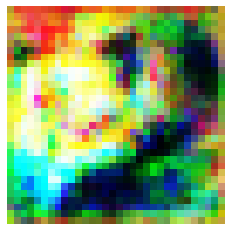

epoch 1
D tf.Tensor(1.9645501, shape=(), dtype=float32) , G tf.Tensor(3.6805677, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.7914851, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.1195676, shape=(), dtype=float32) , D latent loss tf.Tensor(0.05349739, shape=(), dtype=float32)
G adv loss tf.Tensor(0.4105145, shape=(), dtype=float32) G contextual loss tf.Tensor(0.0804231, shape=(), dtype=float32) G latent loss tf.Tensor(0.053128973, shape=(), dtype=float32)


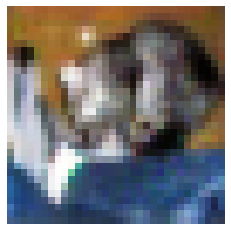

epoch 2
D tf.Tensor(2.093621, shape=(), dtype=float32) , G tf.Tensor(3.2380576, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8210233, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.2148335, shape=(), dtype=float32) , D latent loss tf.Tensor(0.057764255, shape=(), dtype=float32)
G adv loss tf.Tensor(0.38757235, shape=(), dtype=float32) G contextual loss tf.Tensor(0.07003828, shape=(), dtype=float32) G latent loss tf.Tensor(0.048954062, shape=(), dtype=float32)


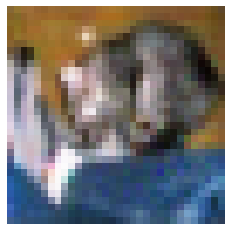

epoch 3
D tf.Tensor(1.9834783, shape=(), dtype=float32) , G tf.Tensor(2.7622504, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.89174575, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.047404, shape=(), dtype=float32) , D latent loss tf.Tensor(0.04432851, shape=(), dtype=float32)
G adv loss tf.Tensor(0.4544675, shape=(), dtype=float32) G contextual loss tf.Tensor(0.05655565, shape=(), dtype=float32) G latent loss tf.Tensor(0.045556758, shape=(), dtype=float32)


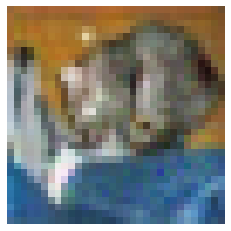

epoch 4
D tf.Tensor(1.9747612, shape=(), dtype=float32) , G tf.Tensor(2.313824, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8660494, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.0613699, shape=(), dtype=float32) , D latent loss tf.Tensor(0.047341995, shape=(), dtype=float32)
G adv loss tf.Tensor(0.45070404, shape=(), dtype=float32) G contextual loss tf.Tensor(0.04559564, shape=(), dtype=float32) G latent loss tf.Tensor(0.039294258, shape=(), dtype=float32)


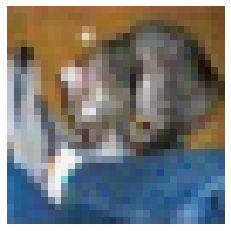

epoch 5
D tf.Tensor(2.0178177, shape=(), dtype=float32) , G tf.Tensor(2.4840424, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.86187625, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.1121907, shape=(), dtype=float32) , D latent loss tf.Tensor(0.04375068, shape=(), dtype=float32)
G adv loss tf.Tensor(0.46810406, shape=(), dtype=float32) G contextual loss tf.Tensor(0.04939231, shape=(), dtype=float32) G latent loss tf.Tensor(0.040245853, shape=(), dtype=float32)


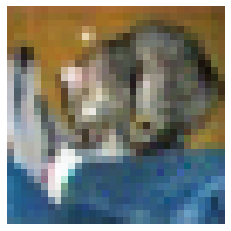

epoch 6
D tf.Tensor(1.9224188, shape=(), dtype=float32) , G tf.Tensor(2.3092136, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8453978, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.0359242, shape=(), dtype=float32) , D latent loss tf.Tensor(0.041096885, shape=(), dtype=float32)
G adv loss tf.Tensor(0.4677324, shape=(), dtype=float32) G contextual loss tf.Tensor(0.045109667, shape=(), dtype=float32) G latent loss tf.Tensor(0.03709463, shape=(), dtype=float32)


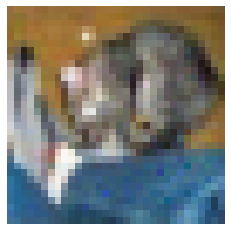

epoch 7
D tf.Tensor(2.0000644, shape=(), dtype=float32) , G tf.Tensor(2.424838, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8619743, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.0949583, shape=(), dtype=float32) , D latent loss tf.Tensor(0.043131802, shape=(), dtype=float32)
G adv loss tf.Tensor(0.46350583, shape=(), dtype=float32) G contextual loss tf.Tensor(0.04802467, shape=(), dtype=float32) G latent loss tf.Tensor(0.0403454, shape=(), dtype=float32)


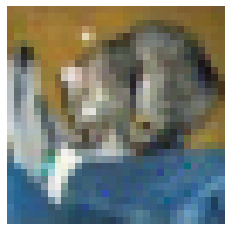

epoch 8
D tf.Tensor(1.9910537, shape=(), dtype=float32) , G tf.Tensor(2.1814432, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8312123, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.1120625, shape=(), dtype=float32) , D latent loss tf.Tensor(0.04777893, shape=(), dtype=float32)
G adv loss tf.Tensor(0.46094146, shape=(), dtype=float32) G contextual loss tf.Tensor(0.04175966, shape=(), dtype=float32) G latent loss tf.Tensor(0.050115302, shape=(), dtype=float32)


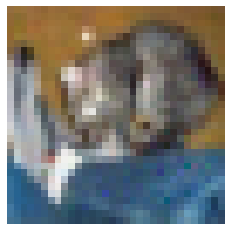

epoch 10
D tf.Tensor(2.0244658, shape=(), dtype=float32) , G tf.Tensor(2.1018968, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8479394, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.1269596, shape=(), dtype=float32) , D latent loss tf.Tensor(0.04956698, shape=(), dtype=float32)
G adv loss tf.Tensor(0.37742323, shape=(), dtype=float32) G contextual loss tf.Tensor(0.041924246, shape=(), dtype=float32) G latent loss tf.Tensor(0.047503706, shape=(), dtype=float32)


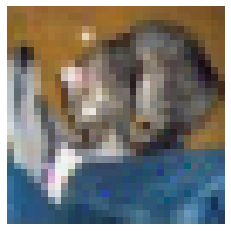

epoch 11
D tf.Tensor(1.9976836, shape=(), dtype=float32) , G tf.Tensor(1.9599072, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.86204875, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.0902747, shape=(), dtype=float32) , D latent loss tf.Tensor(0.04536023, shape=(), dtype=float32)
G adv loss tf.Tensor(0.46788362, shape=(), dtype=float32) G contextual loss tf.Tensor(0.03635522, shape=(), dtype=float32) G latent loss tf.Tensor(0.037814718, shape=(), dtype=float32)


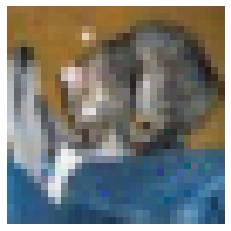

epoch 12
D tf.Tensor(2.0494504, shape=(), dtype=float32) , G tf.Tensor(2.0207648, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.9053903, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.0947833, shape=(), dtype=float32) , D latent loss tf.Tensor(0.04927674, shape=(), dtype=float32)
G adv loss tf.Tensor(0.43210655, shape=(), dtype=float32) G contextual loss tf.Tensor(0.03853979, shape=(), dtype=float32) G latent loss tf.Tensor(0.047066726, shape=(), dtype=float32)


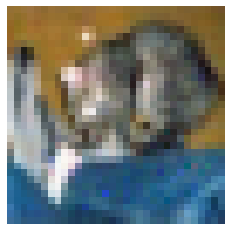

epoch 13
D tf.Tensor(1.9069332, shape=(), dtype=float32) , G tf.Tensor(2.2567, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8574076, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.01145, shape=(), dtype=float32) , D latent loss tf.Tensor(0.038075596, shape=(), dtype=float32)
G adv loss tf.Tensor(0.4393409, shape=(), dtype=float32) G contextual loss tf.Tensor(0.044520915, shape=(), dtype=float32) G latent loss tf.Tensor(0.036522575, shape=(), dtype=float32)


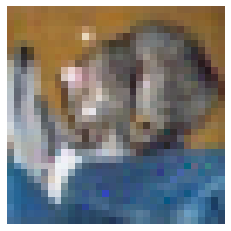

epoch 14
D tf.Tensor(2.0517209, shape=(), dtype=float32) , G tf.Tensor(2.1867032, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.8456653, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.1594629, shape=(), dtype=float32) , D latent loss tf.Tensor(0.04659266, shape=(), dtype=float32)
G adv loss tf.Tensor(0.4058866, shape=(), dtype=float32) G contextual loss tf.Tensor(0.043180585, shape=(), dtype=float32) G latent loss tf.Tensor(0.053593133, shape=(), dtype=float32)


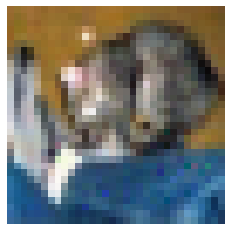

epoch 15
D tf.Tensor(1.9915118, shape=(), dtype=float32) , G tf.Tensor(1.8169677, shape=(), dtype=float32)
D adv loss real tf.Tensor(0.82068354, shape=(), dtype=float32) , D adv loss fake tf.Tensor(1.1254423, shape=(), dtype=float32) , D latent loss tf.Tensor(0.045386054, shape=(), dtype=float32)
G adv loss tf.Tensor(0.38370317, shape=(), dtype=float32) G contextual loss tf.Tensor(0.034751795, shape=(), dtype=float32) G latent loss tf.Tensor(0.04319267, shape=(), dtype=float32)


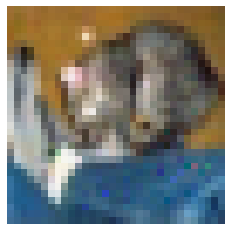

In [22]:
train(x_train, n_epochs=16, n_batch=32, x_val=x_test_normal)

学習曲線

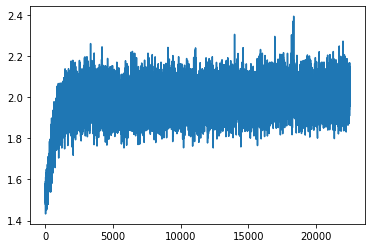

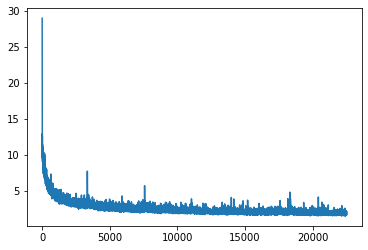

In [23]:
d_losses = np.array(d_history)[:,0]
g_losses = np.array(g_history)[:,0]

plt.plot(d_losses)
plt.show()

plt.plot(g_losses)
plt.show()

# 4. 学習済みモデルの評価

異常スコアを計算する関数を実装しておく：

In [24]:
def anomaly_score(x_batch, pred_model=gan_G, lam=0.9):
    _, x_subtruct, feat_subtruct = pred_model.predict(x_batch)
    R = np.mean(np.abs(x_subtruct), axis=(1,2,3))
    L = np.mean(feat_subtruct**2, axis=-1)
    A = lam*R + (1-lam)*L
    return A

早速、学習済みモデルをテストしてみよう。すぐさま過学習するので、エポック選択が重要だが、ここではsloppyにテストデータで見てしまおう（本当は検証データでエポック数を選ぶこと！! このように選んだ結果を論文に書いたら、これはモデル選択を介した典型的なスヌーピングです。）

<b>6エポック</b>

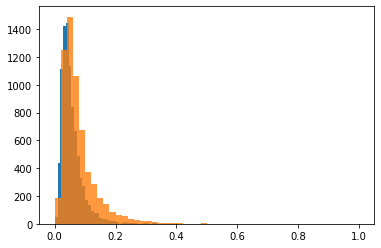

In [25]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_5epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>7エポック</b>

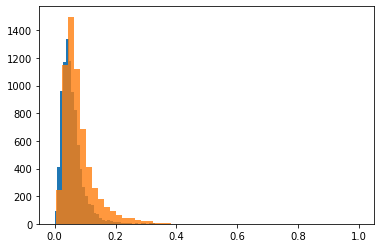

In [26]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_6epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>8エポック</b>

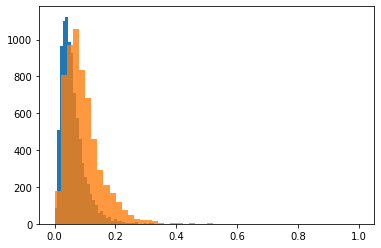

In [27]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_7epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

<b>9エポック</b>

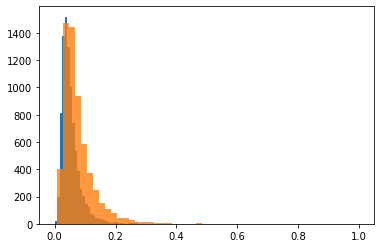

In [28]:
gan_G.load_weights(DATASET_PATH + '/skip_GANomaly_8epochs.h5')

score_anom = anomaly_score(x_test_anom, pred_model=gan_G)
score_norm = anomaly_score(x_test_normal, pred_model=gan_G)
scores = np.concatenate([score_anom,score_norm], axis=0)

score_min, score_max = np.min(scores), np.max(scores)

score_anom = (score_anom - score_min)/(score_max- score_min)
score_norm = (score_norm - score_min)/(score_max- score_min)

plt.hist(score_norm, bins=50)
plt.hist(score_anom, bins=50, alpha=0.8)
plt.show()

# 問題

学習済みの重み（7エポック）を配布したので、このモデルに対して異常検知のAUCを測りましょう。

また、y=0以外のクラスについても学習させ、異常カテゴリごとのAUCの違いを観察せよ（GANomalyなどの論文の結果と比べてみるとよい）。

またこの実装が原実装の細部を再現している保証はないので、詳しく調べてこのコードを改善せよ（そして調査結果を私に教えてください…）。